In [352]:
import os, subprocess, warnings
from datetime import datetime
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import datetime
from scipy.integrate import quad, quad_vec, trapz, cumtrapz
from scipy.optimize import fsolve
from scipy.ndimage import gaussian_filter
from scipy.special import erf
from scipy.interpolate import griddata, interpn
from scipy.signal import welch

from sim import *
import const


In [522]:
#sim_eps0p01 = Sim(ALPHA_EPS0P01, "gridded_data_small.npz", epsilon_SF=0.01)
#sim_eps0p1 = Sim(ALPHA_EPS0P1, "gridded_data_small.npz", epsilon_SF=0.1)
sim_eps1p0 = Sim(ALPHA_EPS1P0, "gridded_data_small.npz", epsilon_SF=1.0)
#sim_gas = Sim(GAS, "gridded_data_small.npz", epsilon_SF=None)
#list_of_sim = [sim_eps0p01, sim_eps0p1, sim_eps1p0, sim_gas]


Moving to directory '/home/za9132/scratch/romain/alpha_eps1p0'.


In [523]:
sim = sim_eps1p0


### Accretion

In [524]:
def calc_norm(a):
    ''' Compute the norm of a vector. '''
    return np.sqrt(np.sum(a**2, axis=0))

def calc_dot(a, b):
    ''' Compute the dot product of two vectors '''
    return np.sum(a * b, axis=0)

def calc_proj(a, b, do_norm=True):
    ''' Compute the projection of one vector onto another '''
    if do_norm:
        return calc_dot(a, b) / calc_norm(b)
    else:
        return (calc_dot(a, b) / calc_norm(b)**2)[None, :, :, :] * b
    
def symlog(x, C):
    ''' Compute the symmetric log '''
    return np.sign(x) * np.log10(1 + np.abs(x / C))


In [525]:
h = np.cross(sim.coord, sim.vel_vec, axis=0)
h_tot = sim.calc_mean(h, weight=(sim.density * sim.dV), axis=(1, 2, 3), do_sum=True)
h_scalar = calc_proj(h, h_tot[:, None, None, None])

Ldot = sim.interp_to_sph(h_scalar * sim.density * sim.vel_vec_sph_at_cart[R]) * sim.dA_hph
Ldot_1d = sim.calc_mean(Ldot, axis=(1, 2), do_sum=True)


Saved figure as 'L-axis-100520231447.png'


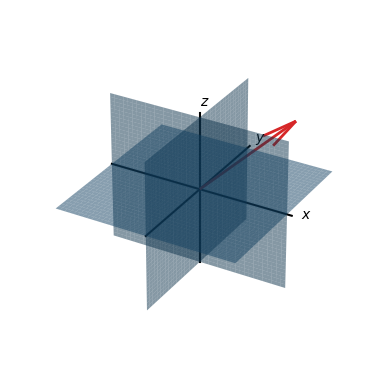

In [526]:
ax = plt.figure().add_subplot(projection='3d')

x, y = np.mgrid[-1:1:0.05, -1:1:0.05]
z = np.zeros_like(x)

ax.plot_surface(x, y, z, color='C0', alpha=0.5)
ax.plot_surface(z, y, x, color='C0', alpha=0.5)
ax.plot_surface(x, z, y, color='C0', alpha=0.5)

ax.quiver(0, 0, 0, h_tot[X], h_tot[Y], h_tot[Z], length=1.2, normalize=True, lw=2, color='C3')

ax.plot([-1, 1], [0, 0], [0, 0], color='black')
ax.plot([0, 0], [-1, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 0], [-1, 1], color='black')

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

ax.axis("off")

ax.text(1.1, 0, 0, r"$x$")
ax.text(0, 1.1, 0, r"$y$")
ax.text(0, 0, 1.1, r"$z$")

sim.save_fig("L-axis")


Saved figure as 'Ldot-100520231447.png'


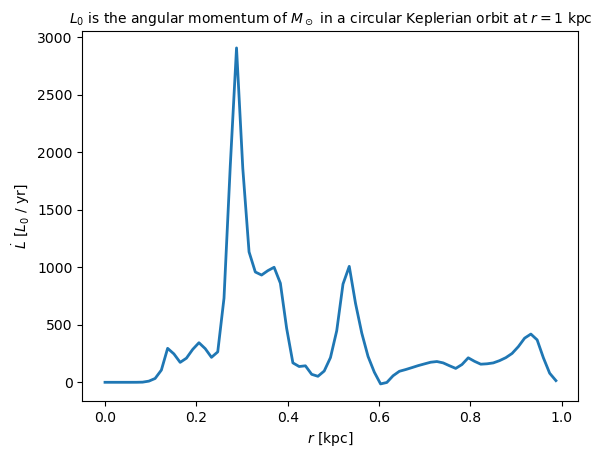

In [527]:
radius = 1 * const.kpc
M_enc = sim.calc_mean(sim.density * sim.dV, cond=(sim.r < radius), do_sum=True)
L0 = const.M_sol * np.sqrt(const.G * M_enc * radius)

plt.plot(sim.coord_r_1d / const.kpc, Ldot_1d / (L0 / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{L}$ [$L_0~/~{\rm yr}$]")

plt.title(r"$L_0$ is the angular momentum of $M_\odot$ in a circular Keplerian orbit at $r = %.3g~{\rm kpc}$" % (radius / const.kpc), fontsize=10)

sim.save_fig("Ldot")


In [528]:
Mdot = -sim.interp_to_sph(sim.vel_vec_sph_at_cart[R] * sim.density) * sim.dA_hph
Mdot_1d = sim.calc_mean(Mdot, axis=(1, 2), do_sum=True)
density_sph = sim.interp_to_sph(sim.density)


Saved figure as 'Mdot-100520231447.png'


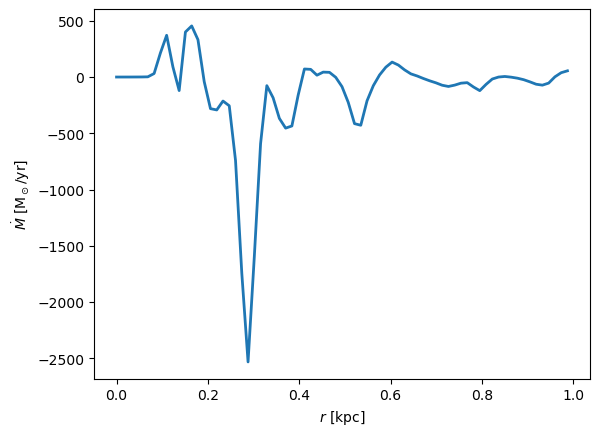

In [529]:
plt.plot(sim.coord_r_1d / const.kpc, Mdot_1d / (const.M_sol / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{M}$ [${\rm M_\odot/yr}$]")

sim.save_fig("Mdot")


Saved figure as 'Mdot-sph-100520231447.png'


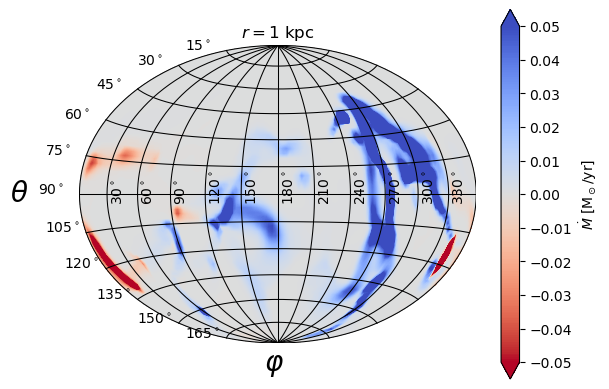

In [530]:
radius = 1. * const.kpc
radius_idx = np.argmin(np.abs(sim.coord_r_1d - radius))

sim.plot_AH(Mdot[radius_idx] / (const.M_sol / const.yr), (-0.05, 0.05), do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.01, cbar_label=r'$\dot{M}$ [${\rm M_\odot/yr}$]')

plt.title(r"$r = %.3g~{\rm kpc}$" % (radius / const.kpc))

sim.save_fig("Mdot-sph")


Saved figure as 'Mdot-sph-avg-100520231447.png'


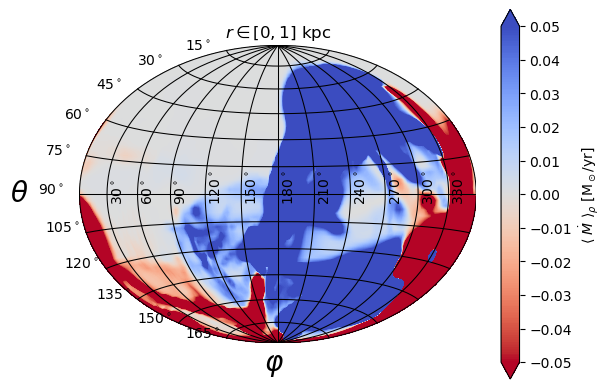

In [531]:
radius_in, radius_out = 0. * const.kpc, 1 * const.kpc
cond = (sim.coord_sph[R] < radius_out) * (sim.coord_sph[R] > radius_in)

Mdot_avg = sim.calc_mean(Mdot, weight=(density_sph * sim.dr), cond=cond, axis=R)

sim.plot_AH(Mdot_avg / (const.M_sol / const.yr), (-0.05, 0.05), do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.01, cbar_label=r'$\langle~\dot{M}~\rangle_\rho$ [${\rm M_\odot/yr}$]')

plt.title(r"$r \in [%.3g, %.3g]~{\rm kpc}$" % (radius_in / const.kpc, radius_out / const.kpc))

sim.save_fig("Mdot-sph-avg")


### Dust

Saved figure as 'metal-proj-x-100520231447.png'


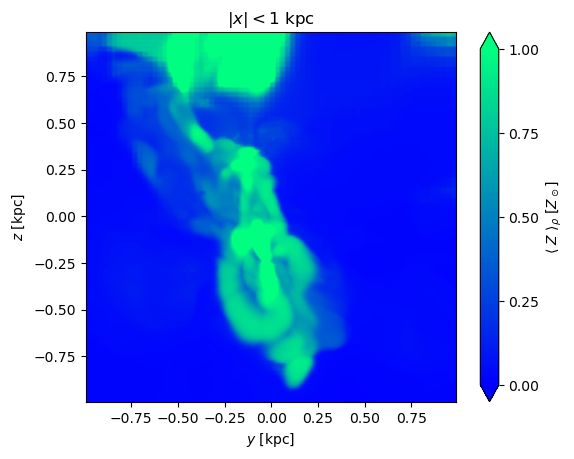

In [534]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.metallicity / const.Z_sol, (0, 1), avg=True, slice=slice, weight=sim.density, project=True, do_log=False, cmap='winter', cbar_label=r'$\langle~Z~\rangle_\rho$ [$Z_\odot$]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("metal-proj-%s" % slice_label)


Saved figure as 'dust-proj-x-100520231447.png'


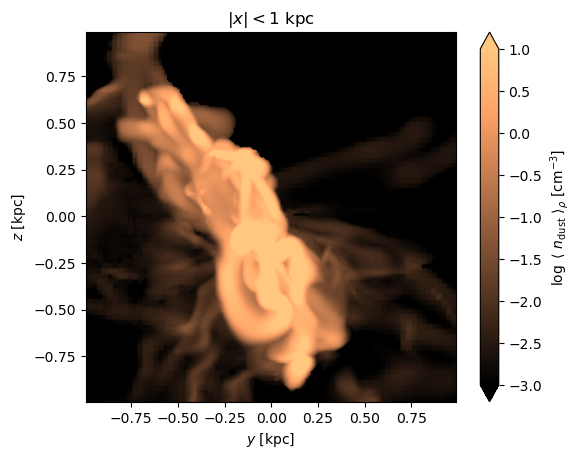

In [537]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.n_dust, (1e-3, 1e1), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='copper', cbar_label=r'$\log~\langle~n_{\rm dust}~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("dust-proj-%s" % slice_label)


Saved figure as 'dust-sph-100520231447.png'


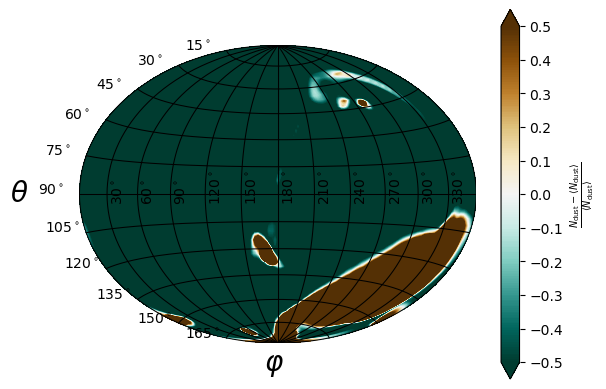

In [538]:
n_dust_sph = sim.interp_to_sph(sim.n_dust)
N_dust = np.sum(n_dust_sph * sim.dr, axis=R)
N_dust_avg = np.sum(N_dust * sim.dA_hph[-1]) / np.sum(sim.dA_hph[-1])
N_dust_delta = (N_dust - N_dust_avg) / N_dust_avg

sim.plot_AH(N_dust_delta, (-0.5, 0.5), do_log=False, cmap='BrBG_r', num_axis_lines=12, cbar_tick_increment=0.1, cbar_label=r'$\frac{N_{\rm dust} - \langle N_{\rm dust}\rangle}{\langle N_{\rm dust}\rangle}$')
        
sim.save_fig("dust-sph")
    

### Multi-freefall Model

Saved figure as 'SFR-proj-z-100520231448.png'


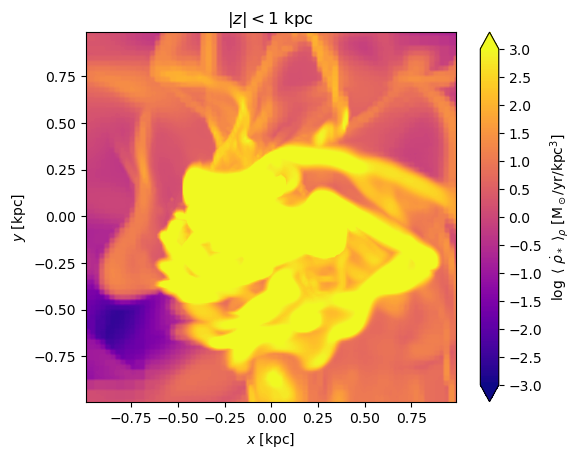

In [541]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.SFR_density / (const.M_sol / const.yr / const.kpc**3), (1e-3, 1e3), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='plasma', cbar_label=r'$\log~\langle~\dot{\rho}_*~\rangle_\rho$ [${\rm M_\odot/yr/kpc^3}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("SFR-proj-%s" % slice_label)


### Gas Properties

Saved figure as 'v-proj-z-100520231448.png'


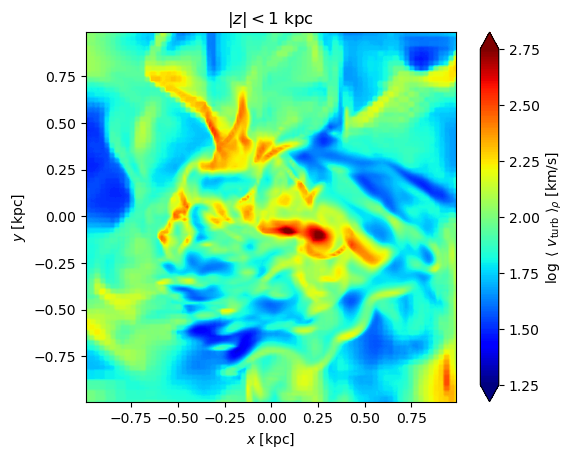

In [544]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.v_turb / (const.km), (10**(1.25), 10**(2.75)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='jet', cbar_label=r'$\log~\langle~v_{\rm turb}~\rangle_\rho$ [km/s]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("v-proj-%s" % slice_label)


Saved figure as 'mach-proj-x-100520231448.png'


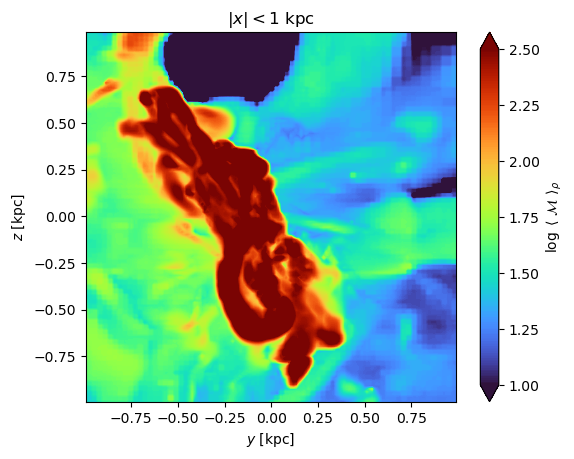

In [547]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.mach, (10**(1.), 10**(2.5)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='turbo', cbar_label=r'$\log~\langle~\mathcal{M}~\rangle_\rho$', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("mach-proj-%s" % slice_label)


Saved figure as 'temp-proj-x-100520231448.png'


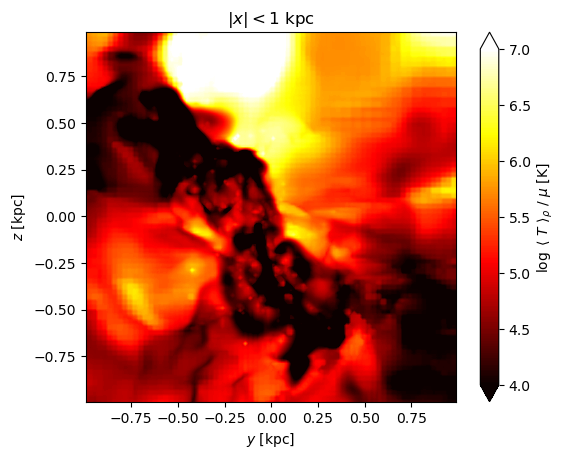

In [550]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.temperature, (1e4, 1e7), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='hot', cbar_label=r'$\log~\langle~T~\rangle_\rho~/~\mu$ [K]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("temp-proj-%s" % slice_label)


Saved figure as 'density-proj-x-100520231448.png'


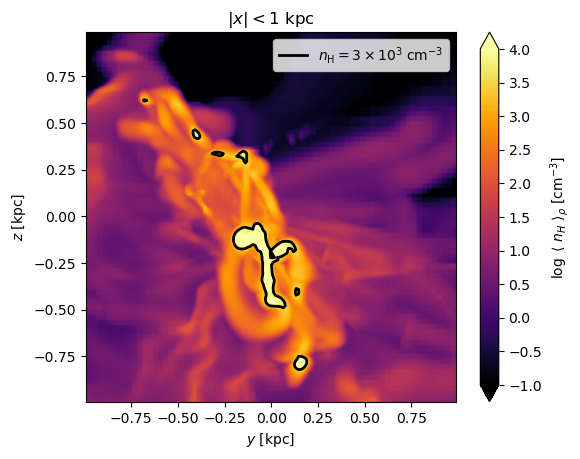

In [553]:
slice = X
slice_label = ["x", "y", "z"][slice]

n_H_crit_ffb = 3e3
cond_ffb = sim.n_H < n_H_crit_ffb

sim.plot_slice(sim.n_H, (1e-1, 1e4), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='inferno', cbar_label=r'$\log~\langle~n_H~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5, isocontours=[n_H_crit_ffb])

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

custom_lines = [Line2D([0], [0], color='black', lw=2)]
plt.legend(custom_lines, [r'$n_{\rm H} = 3\times 10^{3}~{\rm cm^{-3}}$'])

sim.save_fig("density-proj-%s" % slice_label)


In [554]:
n_H_2d, temperature_2d, mass_2d = sim.calc_phase(sim.n_H, sim.temperature, (1e-4, 1e5), (1e1, 1e9), nbins=200)


Saved figure as 'density-temp-phase-100520231448.png'


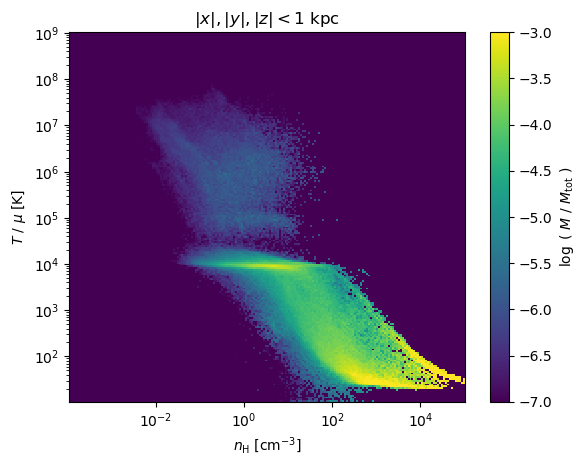

In [555]:
mass_frac_2d = mass_2d / np.sum(sim.density * sim.dV)

plt.pcolor(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-7, vmax=-3)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T~/~\mu$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

sim.save_fig("density-temp-phase")


In [556]:
r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)


Saved figure as 'density-1d-100520231448.png'


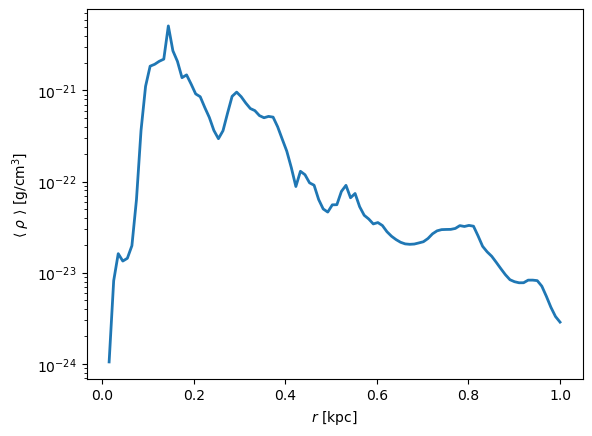

In [557]:
plt.plot(r_1d / const.kpc, density_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.yscale('log')

sim.save_fig("density-1d")


In [558]:
r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)


Saved figure as 'temp-1d-100520231448.png'


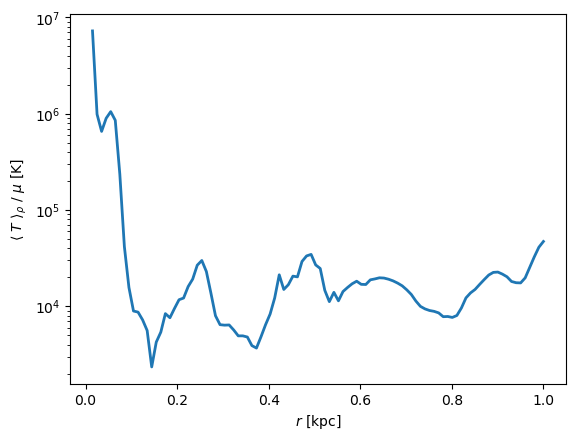

In [559]:
plt.plot(r_1d / const.kpc, temperature_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.yscale('log')

sim.save_fig("temp-1d")


In [560]:
r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
v_turb_1d = np.sqrt(2 * turb_energy_1d)


Saved figure as 'v-turb-1d-100520231448.png'


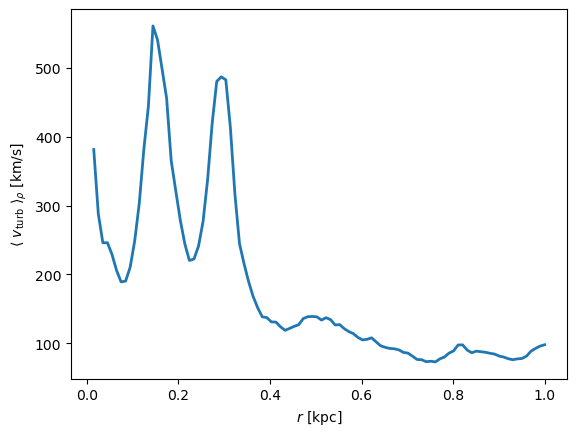

In [561]:
plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

sim.save_fig("v-turb-1d")


### Refinement

Saved figure as 'refine-proj-x-100520231448.png'


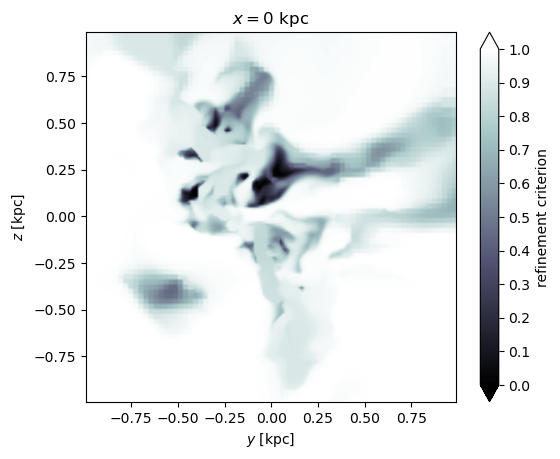

In [564]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.refinement_criterion, (0., 1.), slice=slice, project=False, do_log=False, cmap='bone', cbar_label='refinement criterion', cbar_tick_increment=0.1)

plt.title(r'$%s = 0~{\rm kpc}$' % slice_label)

sim.save_fig("refine-proj-%s" % slice_label)


### Star Formation Rate

Saved figure as 'SFR-100520231449.png'


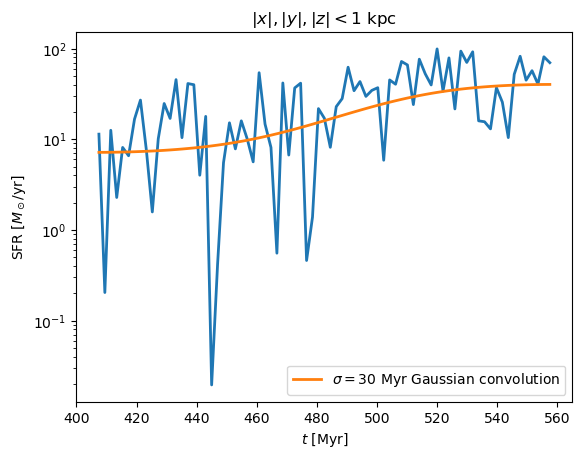

In [570]:
nbins = 150
filter_sigma = 30 * const.Myr
t_range = 150 * const.Myr

counts, bins = np.histogram(sim.star_birth_time, bins=nbins, weights=sim.star_mass)

star_birth_time = bins[:-1] + np.diff(bins)[0]
t_min_idx = np.argmin(np.abs(star_birth_time + t_range - sim.current_time))
star_mass = counts
SFR_mass = star_mass / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birth_time)[0]
SFR_mass_smoothed = 10**gaussian_filter(np.log10(SFR_mass[t_min_idx:] + epsilon), sigma=filter_sigma_idx)

plt.plot(star_birth_time[t_min_idx:] / const.Myr, SFR_mass[t_min_idx:] / const.M_sol * const.yr, lw=2, color='C0')
plt.plot(star_birth_time[t_min_idx:] / const.Myr, SFR_mass_smoothed / const.M_sol * const.yr, lw=2, color='C1', label=r'$\sigma = %.3g~{\rm Myr}$ Gaussian convolution' % (filter_sigma / const.Myr))

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.yscale('log')

plt.legend()

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

sim.save_fig("SFR")


Saved figure as 'SFR-res-100520231449.png'


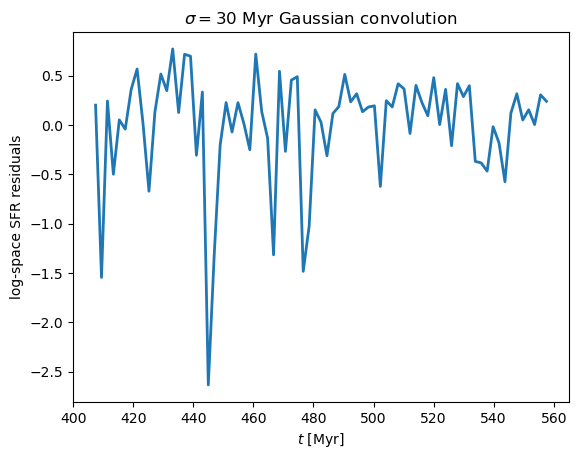

In [571]:
log_SFR_res = np.log10(SFR_mass[t_min_idx:]) - np.log10(SFR_mass_smoothed)

plt.plot(star_birth_time[t_min_idx:] / const.Myr, log_SFR_res, lw=2)

plt.ylabel(r"log-space SFR residuals")
plt.xlabel(r"$t$ [Myr]")

plt.title(r'$\sigma = %.3g~{\rm Myr}$ Gaussian convolution' % (filter_sigma / const.Myr))

sim.save_fig("SFR-res")


/usr/licensed/anaconda3/2023.3/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 77, using nperseg = 77
  warnings.warn('nperseg = {0:d} is greater than input length '


Saved figure as 'SFR-PSD-100520231449.png'


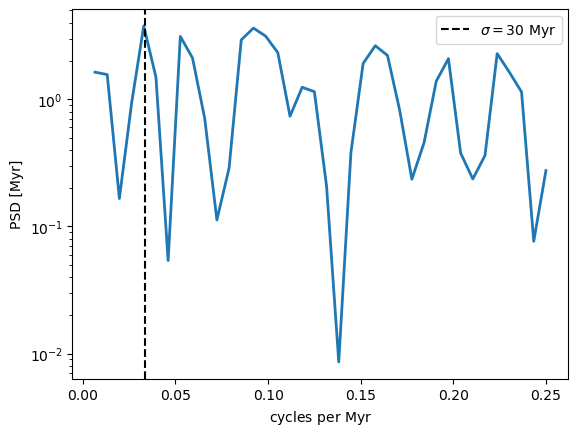

In [572]:
star_birth_time_freqs, log_SFR_res_PSD = welch(log_SFR_res, fs=1/np.diff(star_birth_time)[0], detrend=None, scaling='density', nperseg=256)

plt.plot((star_birth_time_freqs[1:] * const.Myr)**(1), log_SFR_res_PSD[1:] / const.Myr, lw=2)

plt.yscale('log')

plt.axvline(x=(filter_sigma**(-1) * const.Myr), color='black', linestyle='--', label=r'$\sigma = %.3g~{\rm Myr}$' % (filter_sigma / const.Myr))

plt.legend()

plt.xlabel(r"${\rm cycles\ per\ Myr}$")
plt.ylabel(r"PSD [Myr]")

sim.save_fig("SFR-PSD")


### Summary Statistics

In [30]:
stats = {
    'fields': [sim.density, sim.temperature, sim.metallicity / const.Z_sol, sim.v_turb / const.km, sim.mach, sim.star_age / const.Myr],
    'names': ["density", "temperature", "metallicity", "turbulent velocity", "mach number", "star age"],
    'units': ["g/cm^3", "K", "Z_sol", "km/s", "", "Myr"],
    'weights': [None, sim.density, sim.density, sim.density, sim.density, sim.star_mass],
    'types': [HYDRO, HYDRO, HYDRO, HYDRO, HYDRO, STAR]
}

sim.calc_summary_stats(**stats, do_print=True)



Field                            Max        Min           Mean  Unit
-----------------------  -----------  ---------  -------------  ------
density                     5e-20      1.06e-28       1.79e-23  g/cm^3
temperature                 4.61e+08  10.1       424000         K
metallicity                 8.19       0.0649         0.649     Z_sol
turbulent velocity       2900         16.4          166         km/s
mach number              1270          0.0151       149
star age                  294          0.00132       55.1       Myr
star part number            0          0         864000
dark matter part number     0          0         279000
contamination frac          0          0              0


### Simulation Comparison

Saved figure as 'density-compare-092720231131.png'


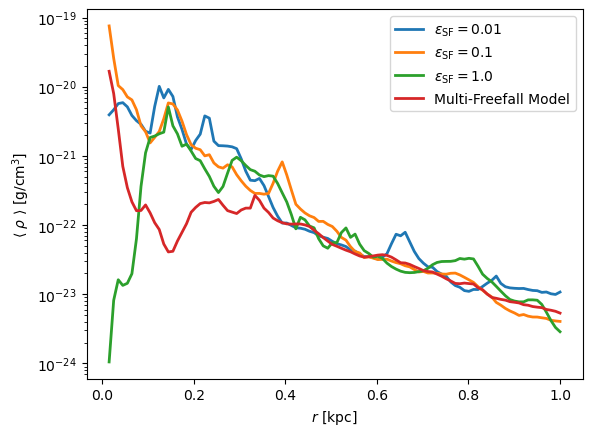

In [54]:
for sim in list_of_sim:
    
    r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, density_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.legend()

plt.yscale('log')

# save_fig('density-compare')


Saved figure as 'v-turb-compare-092720231130.png'


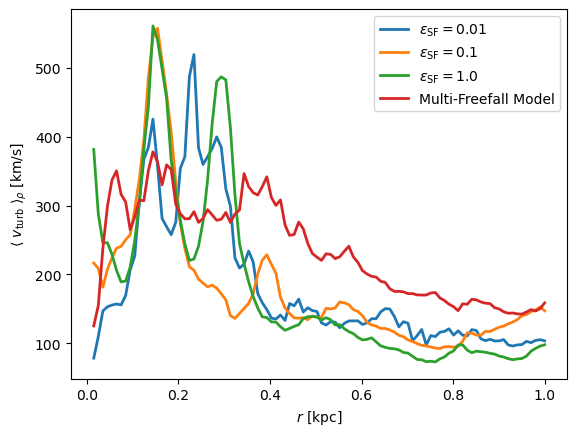

In [53]:
for sim in list_of_sim:
    
    r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
    v_turb_1d = np.sqrt(2 * turb_energy_1d)

    plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

plt.legend()

# save_fig('v-turb-compare')


Saved figure as 'temp-compare-092720231130.png'


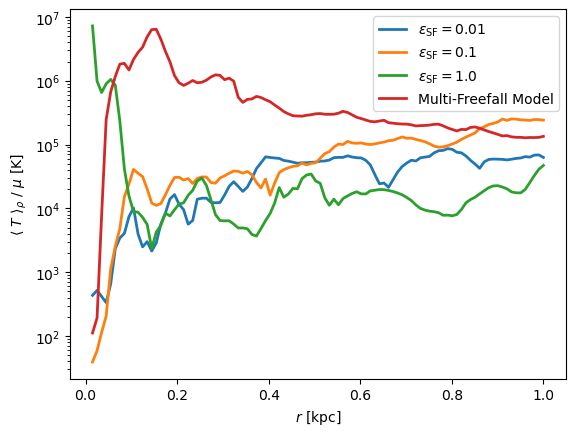

In [52]:
for sim in list_of_sim:
    
    r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, temperature_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.legend()

plt.yscale('log')

# save_fig('temp-compare')


Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$, $\\sigma = 10~{\\rm Myr}$')

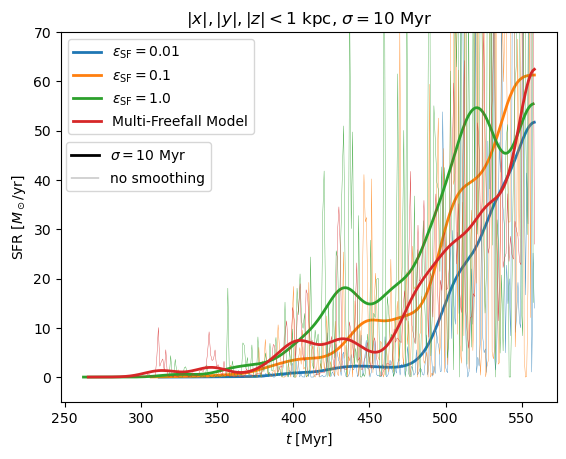

In [26]:
nbins = 300
filter_sigma = 10 * const.Myr

for i, sim in enumerate(list_of_sim):

    counts, bins = np.histogram(sim.star_birth_time, bins=nbins, weights=sim.star_mass)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=0.25, alpha=1., color='C%d' % i)
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, label=sim.sim_latex, color='C%d' % i)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

legend1 = plt.legend()
custom_lines = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=0.25)]
legend2 = plt.legend(custom_lines, [r'$\sigma=10~{\rm Myr}$', 'no smoothing'], loc=[0.01, 0.57])
plt.gca().add_artist(legend1)

plt.ylim(-5, 70)

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$, $\sigma = 10~{\rm Myr}$')

# save_fig('SFR-compare')
